## What is the causal effect of extreme heat on electricity demand in California?

Data Setup: For this question we're combining daily energy data and daily temperature data in California from the years 2016-2023. Weather data was obtained from NOAA, and energy data was taken from the US Energy Information Administration. 

In [54]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def eda(data):
    df = data.copy()
    df = df[['Region', 'UTC time', 'Local date', 'Hour', 'Local time', 'Time zone',
                         'DF', 'D', 'Sum (NG)', 'NG: COL', 'NG: NG', 'NG: NUC',
                         'NG: OIL', 'NG: WAT', 'NG: SUN', 'NG: WND', 'NG: OTH', 'CO2 Emissions Generated']]
    df['Local date'] = pd.to_datetime(df['Local date'], format='%d%b%Y')
    df['day'] = df['Local date'].dt.day
    df['month'] = df['Local date'].dt.month
    df['year'] = df['Local date'].dt.year
    df['dotw'] = df['Local date'].dt.dayofweek
    df = df[(df['year'] >= 2016) & (df['year'] <= 2023)]
    df['Hour'] = df['Hour'] - 1
    df['D'] = pd.to_numeric(df['D'].str.replace(',', '', regex=False), errors='coerce')
    return df

In [56]:
california = eda(pd.read_csv('california.csv', low_memory=False))

In [57]:
california['NG: SUN'] = pd.to_numeric(california['NG: SUN'], errors='coerce')
california['NG: WND'] = pd.to_numeric(california['NG: WND'], errors='coerce')

In [58]:
cal_bydate = california.groupby('Local date')[['D', 'NG: SUN', 'NG: WND']].sum().reset_index()

In [59]:
cal_bydate['Local date'] = pd.to_datetime(cal_bydate['Local date'], format='%d%b%Y')
cal_bydate['day'] = cal_bydate['Local date'].dt.day
cal_bydate['month'] = cal_bydate['Local date'].dt.month
cal_bydate['year'] = cal_bydate['Local date'].dt.year
cal_bydate['dotw'] = cal_bydate['Local date'].dt.dayofweek

In [60]:
cal_bydate

,Local date,D,NG: SUN,NG: WND,day,month,year,dotw
0,2016-01-01,689307,0.0,0.0,1,1,2016,4
1,2016-01-02,690124,0.0,0.0,2,1,2016,5
2,2016-01-03,674717,0.0,0.0,3,1,2016,6
3,2016-01-04,732453,0.0,0.0,4,1,2016,0
4,2016-01-05,757620,0.0,0.0,5,1,2016,1
...,...,...,...,...,...,...,...,...
2917,2023-12-27,699599,-194.0,7360.0,27,12,2023,2
2918,2023-12-28,690170,372.0,5189.0,28,12,2023,3
2919,2023-12-29,679225,11.0,11161.0,29,12,2023,4
2920,2023-12-30,659481,502.0,4064.0,30,12,2023,5


Here we combine the energy & weather columns. Snowfall, percipitation, wind and max temperature data across all recorded stations in California are averaged, making the data granularity daily & statewide.

In [61]:
weather_master = pd.read_csv('weather_master.csv')

In [62]:
# Fill NaN values with 0s

weather_master['PRCP'] = weather_master['PRCP'].fillna(0)
weather_master['SNOW'] = weather_master['SNOW'].fillna(0)
weather_master['AWND'] = weather_master['AWND'].fillna(0)

In [63]:
max_master = weather_master.drop(columns=['TAVG', 'TMIN'])
max_master = max_master.dropna(subset=['TMAX'])
max_master = max_master.groupby('DATE').mean().reset_index()


In [64]:
max_master

,DATE,AWND,PRCP,SNOW,TMAX
0,2016-01-01,0.673798,0.000353,0.003193,46.576471
1,2016-01-02,0.551973,0.002488,0.001658,48.920398
2,2016-01-03,0.633372,0.006017,0.000000,51.752066
3,2016-01-04,0.678843,0.056992,0.004132,51.669421
4,2016-01-05,1.080867,0.404288,0.027823,48.569558
...,...,...,...,...,...
2794,2023-12-27,0.733477,0.056360,0.000000,57.156757
2795,2023-12-28,0.542432,0.048486,0.005405,59.099099
2796,2023-12-29,0.774195,0.093978,0.001808,59.365280
2797,2023-12-30,0.717208,0.172956,0.011861,53.313869


In [65]:
# Ensure the 'Local date' in energy data is in date format (strip time if necessary)
cal_bydate['Local date'] = pd.to_datetime(cal_bydate['Local date']).dt.date

# Ensure the 'DATE' in temperature data is in date format
max_master['DATE'] = pd.to_datetime(max_master['DATE']).dt.date

combined_data = pd.merge(
    cal_bydate,
    max_master,
    left_on="Local date",
    right_on="DATE",
    how="inner"
)

# Drop the duplicate 'DATE' column if it's no longer needed
combined_data.drop(columns=["DATE"], inplace=True)

In [66]:
combined_data

,Local date,D,NG: SUN,NG: WND,day,month,year,dotw,AWND,PRCP,SNOW,TMAX
0,2016-01-01,689307,0.0,0.0,1,1,2016,4,0.673798,0.000353,0.003193,46.576471
1,2016-01-02,690124,0.0,0.0,2,1,2016,5,0.551973,0.002488,0.001658,48.920398
2,2016-01-03,674717,0.0,0.0,3,1,2016,6,0.633372,0.006017,0.000000,51.752066
3,2016-01-04,732453,0.0,0.0,4,1,2016,0,0.678843,0.056992,0.004132,51.669421
4,2016-01-05,757620,0.0,0.0,5,1,2016,1,1.080867,0.404288,0.027823,48.569558
...,...,...,...,...,...,...,...,...,...,...,...,...
2794,2023-12-27,699599,-194.0,7360.0,27,12,2023,2,0.733477,0.056360,0.000000,57.156757
2795,2023-12-28,690170,372.0,5189.0,28,12,2023,3,0.542432,0.048486,0.005405,59.099099
2796,2023-12-29,679225,11.0,11161.0,29,12,2023,4,0.774195,0.093978,0.001808,59.365280
2797,2023-12-30,659481,502.0,4064.0,30,12,2023,5,0.717208,0.172956,0.011861,53.313869


Here we define significant weather events - specifically rain, snow, and wind events - to allow for the matching of those events. All three are defined "significant" if they are in the 90%+ quantile. 

In [67]:
combined_data.columns

Index(['Local date', 'D', 'NG: SUN', 'NG: WND', 'day', 'month', 'year', 'dotw',
       'AWND', 'PRCP', 'SNOW', 'TMAX'],
      dtype='object')

In [68]:
prcp_threshold = combined_data['PRCP'].quantile(0.90)
snow_threshold = combined_data['SNOW'].quantile(0.90)
wind_threshold = combined_data['AWND'].quantile(0.90)


combined_data['Significant_Rain'] = (combined_data['PRCP'] > prcp_threshold).astype(int)
combined_data['Significant_Snow'] = (combined_data['SNOW'] > snow_threshold).astype(int)
combined_data['Significant_Wind'] = (combined_data['AWND'] > snow_threshold).astype(int)

Here we define a new column, "Extreme" that indicates whether that day's weather is extreme. From the OEHHA: "An extreme heat event occurs between April and October when the temperature is at or above a location-specific historical temperature threshold, set at the 95th percentile of daily maximum for daytime extreme events" We will follow that definition for this data. 

In [69]:
percentiles = combined_data.groupby('month')['TMAX'].quantile(0.95).reset_index()
percentiles.columns = ['month', 'TMAX_95th']

combined_data = combined_data.merge(percentiles, on='month', how='left')

combined_data['Extreme'] = combined_data['TMAX'] >= combined_data['TMAX_95th']

In [50]:
combined_data

,Local date,D,NG: SUN,NG: WND,day,month,year,dotw,AWND,PRCP,SNOW,TMAX,Significant_Rain,Significant_Snow,Significant_Wind,TMAX_95th,Extreme
0,2016-01-01,689307,0.0,0.0,1,1,2016,4,0.673798,0.000353,0.003193,46.576471,0,0,1,64.049742,False
1,2016-01-02,690124,0.0,0.0,2,1,2016,5,0.551973,0.002488,0.001658,48.920398,0,0,1,64.049742,False
2,2016-01-03,674717,0.0,0.0,3,1,2016,6,0.633372,0.006017,0.000000,51.752066,0,0,1,64.049742,False
3,2016-01-04,732453,0.0,0.0,4,1,2016,0,0.678843,0.056992,0.004132,51.669421,0,0,1,64.049742,False
4,2016-01-05,757620,0.0,0.0,5,1,2016,1,1.080867,0.404288,0.027823,48.569558,1,0,1,64.049742,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,2023-12-27,699599,-194.0,7360.0,27,12,2023,2,0.733477,0.056360,0.000000,57.156757,0,0,1,64.681460,False
2795,2023-12-28,690170,372.0,5189.0,28,12,2023,3,0.542432,0.048486,0.005405,59.099099,0,0,1,64.681460,False
2796,2023-12-29,679225,11.0,11161.0,29,12,2023,4,0.774195,0.093978,0.001808,59.365280,0,0,1,64.681460,False
2797,2023-12-30,659481,502.0,4064.0,30,12,2023,5,0.717208,0.172956,0.011861,53.313869,1,0,1,64.681460,False


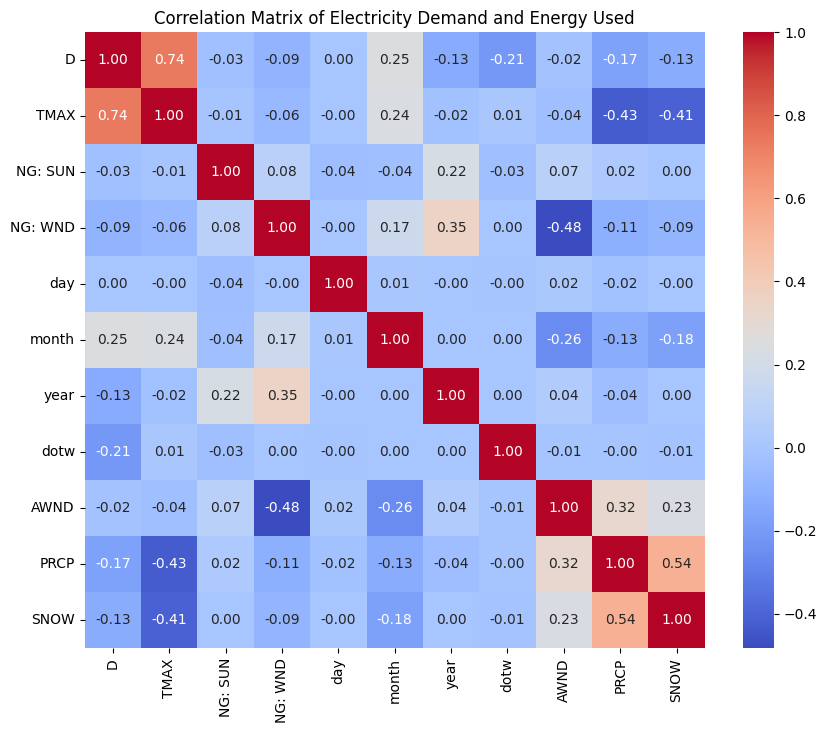

In [71]:
correlation_columns = ['D', 'NG: SUN', 'NG: WND', 'day', 'month', 'year', 'dotw', 'AWND', 'PRCP', 'SNOW', 'TMAX']

# Create correlation matrix and plot 
corr_matrix = combined_data[['D', 'TMAX', 'NG: SUN', 'NG: WND', 'day', 'month', 'year', 'dotw', 'AWND', 'PRCP', 'SNOW']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Electricity Demand and Energy Used')
plt.show()

## Matching

We will utilize matching, joining extreme weather days to non-extreme weather days that share the same day of the week, month, and significant weather attributes. After matching these events we will take the averaged difference between the energy demand of the treated days (days with extreme heat) and untreated days. 

In [250]:
treated = combined_data[combined_data['Extreme'] == 1]
untreated = combined_data[combined_data['Extreme'] == 0]

In [252]:
# Covariates to use for matching
matching_covariates = ['dotw', 'month', 'Significant_Rain', 'Significant_Snow', 'Significant_Wind']

# Merge treated and untreated on matching columns
matched_pairs = pd.merge(
    treated,
    untreated,
    on=matching_covariates,
    suffixes=('_treated', '_untreated')
)

In [254]:
matched_pairs

,Local date_treated,D_treated,NG: SUN_treated,NG: WND_treated,day_treated,month,year_treated,dotw,AWND_treated,PRCP_treated,...,dotw_3_untreated,dotw_4_untreated,dotw_5_untreated,dotw_6_untreated,AWND_normalized_untreated,PRCP_log_untreated,PRCP_normalized_untreated,SNOW_log_untreated,SNOW_normalized_untreated,pscore_untreated
0,2016-07-27,1086421,0.0,0.0,27,7,2016,2,0.848080,0.000050,...,False,False,False,False,0.753264,-13.815511,-2.329482,-13.815511,-0.620342,0.134563
1,2016-07-27,1086421,0.0,0.0,27,7,2016,2,0.848080,0.000050,...,False,False,False,False,-0.272123,-13.815511,-2.329482,-13.815511,-0.620342,0.280113
2,2016-07-27,1086421,0.0,0.0,27,7,2016,2,0.848080,0.000050,...,False,False,False,False,0.113008,-8.690214,-0.744298,-13.815511,-0.620342,0.084804
3,2016-07-27,1086421,0.0,0.0,27,7,2016,2,0.848080,0.000050,...,False,False,False,False,0.196952,-9.581010,-1.019809,-13.815511,-0.620342,0.228653
4,2016-07-27,1086421,0.0,0.0,27,7,2016,2,0.848080,0.000050,...,False,False,False,False,0.290553,-13.815511,-2.329482,-13.815511,-0.620342,0.168258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,2023-07-16,911342,267.0,5493.0,16,7,2023,6,0.845378,0.000184,...,False,False,False,True,0.351829,-5.294309,0.306009,-13.815511,-0.620342,0.158323
849,2023-07-16,911342,267.0,5493.0,16,7,2023,6,0.845378,0.000184,...,False,False,False,True,0.199745,-10.845902,-1.411023,-13.815511,-0.620342,0.260707
850,2023-07-16,911342,267.0,5493.0,16,7,2023,6,0.845378,0.000184,...,False,False,False,True,1.016190,-10.182344,-1.205794,-13.815511,-0.620342,0.109101
851,2023-07-16,911342,267.0,5493.0,16,7,2023,6,0.845378,0.000184,...,False,False,False,True,0.120181,-9.785729,-1.083126,-13.815511,-0.620342,0.117392


In [256]:
att = (matched_pairs['D_treated'] - matched_pairs['D_untreated']).mean()
att

198358.75381008207

This outcome indicates that days exhibiting "extreme" heat (temperatures in the upper 5%) cause a roughly 198,358 MWh increase in demand. Though, this value can change as we change our definitions of what "extreme" heat and "significant weather" is considered. Lowering the threshold of what is considered extreme heat will likely decrease this outcome. Let's consider what this change might look like to get a sense of the causation of various maximum temperatures on energy demand.

In [263]:
import numpy as np

# Define a range of quantile thresholds (e.g., 85% to 99%)
quantiles = np.linspace(0.50, 0.99, 50)  # Adjust as needed

In [265]:
att_results = []
matching_results = []


for q in quantiles:
    tmax_threshold = combined_data['TMAX'].quantile(q)
    
    combined_data['Extreme'] = (combined_data['TMAX'] > tmax_threshold).astype(int)
    
    treated = combined_data[combined_data['Extreme'] == 1]
    untreated = combined_data[combined_data['Extreme'] == 0]
    
    matched_pairs = pd.merge(
        treated,
        untreated,
        on=matching_covariates,
        suffixes=('_treated', '_untreated')
    )

    att = (matched_pairs['D_treated'] - matched_pairs['D_untreated']).mean()
    
    matching_results.append(len(matched_pairs))
    
    att_results.append(att)

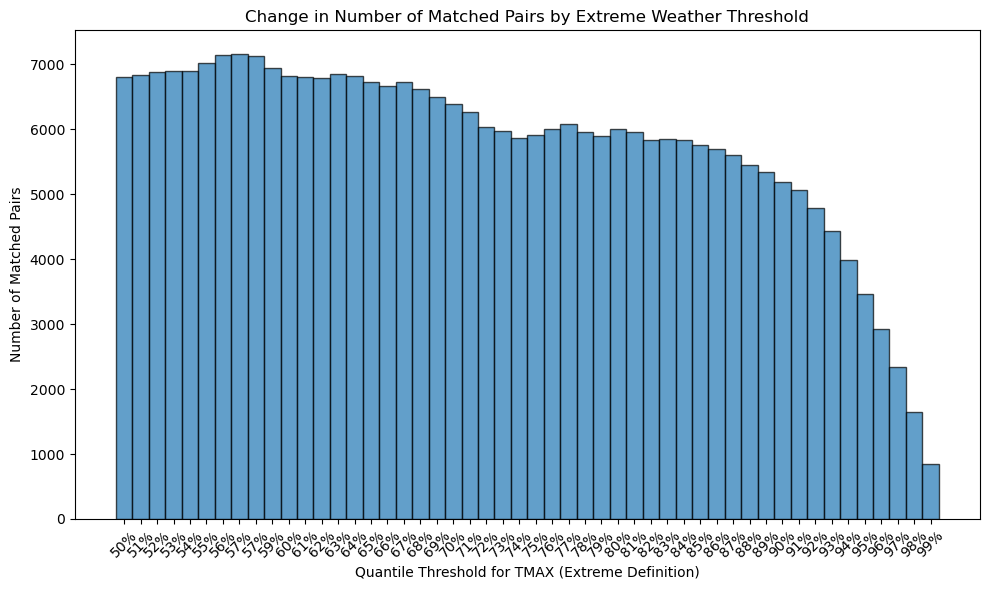

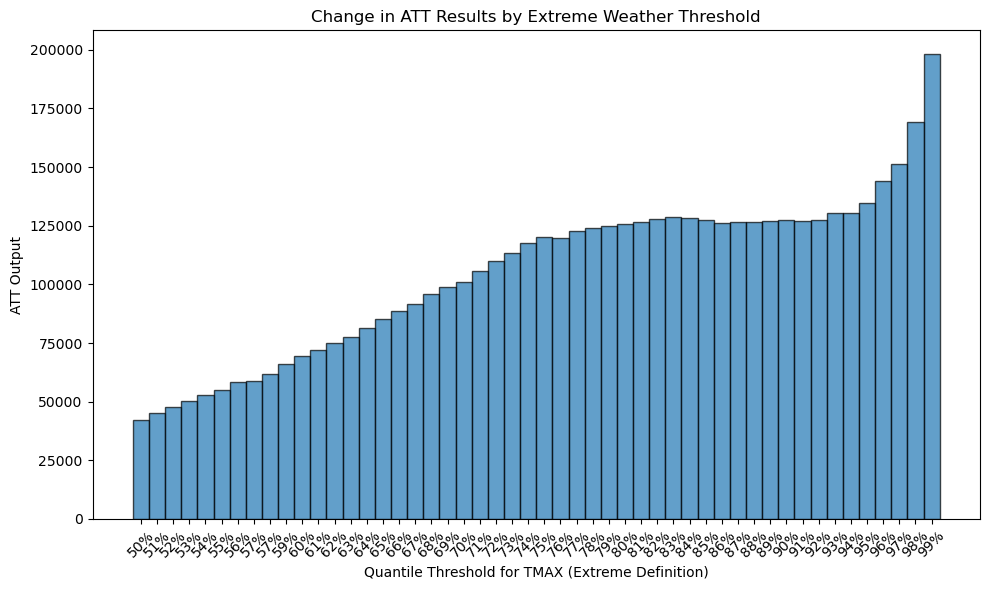

In [267]:
# Matched Pairs
plt.figure(figsize=(10, 6))
plt.bar(quantiles, matching_results, width=0.01, edgecolor='black', alpha=0.7)
plt.xlabel('Quantile Threshold for TMAX (Extreme Definition)')
plt.ylabel('Number of Matched Pairs')
plt.title('Change in Number of Matched Pairs by Extreme Weather Threshold')
plt.xticks(quantiles, labels=[f"{int(q * 100)}%" for q in quantiles], rotation=45)
plt.tight_layout()
plt.show()

# ATT Results
plt.figure(figsize=(10, 6))
plt.bar(quantiles, att_results, width=0.01, edgecolor='black', alpha=0.7)
plt.xlabel('Quantile Threshold for TMAX (Extreme Definition)')
plt.ylabel('ATT Output')
plt.title('Change in ATT Results by Extreme Weather Threshold')
plt.xticks(quantiles, labels=[f"{int(q * 100)}%" for q in quantiles], rotation=45)
plt.tight_layout()
plt.show()

Of note: The ATT value appears to steadily increase as the quantile threshold increases, before flatenning from around 80% to 94%, and then exponentially increases from 95% to 99%. Observing this is relevant as it shows that infrastructure to account for the demand of these 5% events are incredibly important, and also shows that there is little change in demand between the 77% and 93% quantiles. 

In [341]:
quantile_to_att = dict(zip(quantiles, att_results))

What is shown below is that despite having a 5 degree separation, less than the 77-93% quantile's of 7 degrees, the difference between the demand is significantly higher between the 99% and 93% quantile. In fact, the expected difference in demand caused by 95.7 degree max temperatures and 90.6 degrees is over 9 times higher than the same difference between 90.6 and 83.5 degree temperatures.

In [344]:
lower = combined_data['TMAX'].quantile(.77)
upper = combined_data['TMAX'].quantile(.93)

att_difference = quantile_to_att[.9299999999999999] - quantile_to_att[.77]

print("77% Quantile: ", lower, "degrees")
print("93% Quantile: ", upper, "degrees")
print("ATT difference: ", att_difference)

77% Quantile:  83.52000390793178 degrees
93% Quantile:  90.6246949980801 degrees
ATT difference:  7531.6747892686835


In [346]:
lower = combined_data['TMAX'].quantile(.93)
upper = combined_data['TMAX'].quantile(.99)

att_difference = quantile_to_att[.99] - quantile_to_att[.9299999999999999]

print("93% Quantile: ", lower, "degrees")
print("99% Quantile: ", upper, "degrees")
print("ATT difference: ", att_difference)

93% Quantile:  90.6246949980801 degrees
99% Quantile:  95.73183437842142 degrees
ATT difference:  68129.67149163371


## Inverse Propensity Weighting

This is not going great right now. I've attempted to transform some of the non-binary columns to get a more accurate propensity score, but many of my attempts to change the parameters of the logistic regression model cause most of the scores to either be close to 1, or close to 0, creating an extremely high negative output. Obviously days of extreme heat are not causing a 821,239 MWh decrease in demand, so I have reason to believe that I'm either doing something wrong or an IPW approach is not appropriate for this question.

In [225]:
# 1. Process "day" (Cyclical transformation)
combined_data['sine_day'] = np.sin(2 * np.pi * combined_data['day'] / 31)
combined_data['cosine_day'] = np.cos(2 * np.pi * combined_data['day'] / 31)

# 2. Process "month" (Cyclical transformation)
combined_data['sine_month'] = np.sin(2 * np.pi * combined_data['month'] / 12)
combined_data['cosine_month'] = np.cos(2 * np.pi * combined_data['month'] / 12)

# 3. Process "year" (Normalize)
combined_data['year_normalized'] = (combined_data['year'] - combined_data['year'].mean()) / combined_data['year'].std()

# 4. Process "dotw" (One-hot encode)
dotw_encoded = pd.get_dummies(combined_data['dotw'], prefix='dotw', drop_first=False)
combined_data = pd.concat([combined_data, dotw_encoded], axis=1)

# 5. Process "AWND" (Normalize)
combined_data['AWND_normalized'] = (combined_data['AWND'] - combined_data['AWND'].mean()) / combined_data['AWND'].std()

# 6. Process "PRCP" (Log-transform and normalize)
combined_data['PRCP_log'] = np.log(combined_data['PRCP'] + 1e-6)
combined_data['PRCP_normalized'] = (combined_data['PRCP_log'] - combined_data['PRCP_log'].mean()) / combined_data['PRCP_log'].std()

# 7. Process "SNOW" (Log-transform and normalize)
combined_data['SNOW_log'] = np.log(combined_data['SNOW'] + 1e-6)
combined_data['SNOW_normalized'] = (combined_data['SNOW_log'] - combined_data['SNOW_log'].mean()) / combined_data['SNOW_log'].std()

In [227]:
combined_data

,Local date,D,NG: SUN,NG: WND,day,month,year,dotw,AWND,PRCP,...,dotw_2,dotw_3,dotw_4,dotw_5,dotw_6,AWND_normalized,PRCP_log,PRCP_normalized,SNOW_log,SNOW_normalized
0,2016-01-01,689307,0.0,0.0,1,1,2016,4,0.673798,0.000353,...,False,False,True,False,False,-0.775056,-7.946380,-0.514240,-5.746394,1.191593
1,2016-01-02,690124,0.0,0.0,2,1,2016,5,0.551973,0.002488,...,False,False,False,True,False,-1.273264,-5.996050,0.088970,-6.401314,1.044529
2,2016-01-03,674717,0.0,0.0,3,1,2016,6,0.633372,0.006017,...,False,False,False,False,True,-0.940382,-5.113079,0.362061,-13.815511,-0.620342
3,2016-01-04,732453,0.0,0.0,4,1,2016,0,0.678843,0.056992,...,False,False,False,False,False,-0.754426,-2.864831,1.057413,-5.488696,1.249459
4,2016-01-05,757620,0.0,0.0,5,1,2016,1,1.080867,0.404288,...,False,False,False,False,False,0.889670,-0.905625,1.663369,-3.581848,1.677645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,2023-12-27,699599,-194.0,7360.0,27,12,2023,2,0.733477,0.056360,...,True,False,False,False,False,-0.530996,-2.875971,1.053968,-13.815511,-0.620342
2795,2023-12-28,690170,372.0,5189.0,28,12,2023,3,0.542432,0.048486,...,False,True,False,False,False,-1.312283,-3.026450,1.007427,-5.220171,1.309757
2796,2023-12-29,679225,11.0,11161.0,29,12,2023,4,0.774195,0.093978,...,False,False,True,False,False,-0.364478,-2.364681,1.212103,-6.314805,1.063955
2797,2023-12-30,659481,502.0,4064.0,30,12,2023,5,0.717208,0.172956,...,False,False,False,True,False,-0.597530,-1.754711,1.400758,-4.434389,1.486206


In [231]:
X = combined_data[['year_normalized', 'sine_day', 'cosine_day', 'sine_month', 
                   'cosine_month', 'AWND_normalized', 'PRCP_log', 'PRCP_normalized', 
                   'SNOW_log', 'SNOW_normalized', 'dotw_1', 'dotw_2', 'dotw_3', 'dotw_4', 'dotw_5', 'dotw_6']]
y = combined_data['Extreme']

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
model = LogisticRegression()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

LogisticRegression(max_iter=1000)

In [235]:
propensity_scores = model.predict_proba(X)[:, 1]
propensity_df = pd.DataFrame(propensity_scores, columns=['Propensity Score'])
propensity_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Propensity Score
0,0.000519
1,0.001444
2,0.006899
3,0.000481
4,0.000024
...,...
2794,0.002825
2795,0.000981
2796,0.000447
2797,0.000469


In [237]:
propensity_df.describe()

,Propensity Score
count,2.799000e+03
mean,5.803401e-02
std,8.918480e-02
min,1.751183e-07
25%,6.836072e-04
50%,1.281362e-02
75%,8.613814e-02
max,6.646923e-01


In [239]:
combined_data['pscore'] = propensity_scores

In [241]:
narrowed_prop = combined_data[(combined_data['pscore'] > 0.1) & (combined_data['pscore'] < 0.9)]
n = len(narrowed_prop)
treated_rows_cleaned = narrowed_prop.loc[narrowed_prop['Extreme'] == 1].copy()
untreated_rows_cleaned = narrowed_prop.loc[narrowed_prop['Extreme'] == 0].copy()
treated_rows_cleaned['Weighted Demand'] = treated_rows_cleaned['D'] * (1 / treated_rows_cleaned['pscore'])
untreated_rows_cleaned['Weighted Demand'] = untreated_rows_cleaned['D'] * (1 / (1 - untreated_rows_cleaned['pscore']))
trimmed_ipw_estimate = ((1 / n) * treated_rows_cleaned['Weighted Demand'].sum()) - ((1 / n) * untreated_rows_cleaned['Weighted Demand'].sum())
trimmed_ipw_estimate

-821239.3966839692

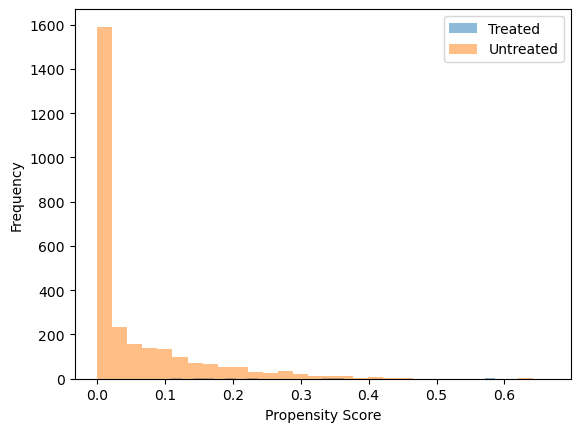

In [243]:
import matplotlib.pyplot as plt

plt.hist(combined_data.loc[combined_data['Extreme'] == 1, 'pscore'], bins=30, alpha=0.5, label='Treated')
plt.hist(combined_data.loc[combined_data['Extreme'] == 0, 'pscore'], bins=30, alpha=0.5, label='Untreated')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()